In [1]:
import os
os.chdir("../")

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from utils import *
import matplotlib

matplotlib.get_cachedir()
plt.rc('font', family="Times New Roman")
from sklearn import metrics

import json

In [53]:
def visualization(image, submodular_image_set, saved_json_file, index=None):
    insertion_ours_images = []
    deletion_ours_images = []

    insertion_image = submodular_image_set[0] - submodular_image_set[0]
    insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image - insertion_image)
    for smdl_sub_mask in submodular_image_set[:]:
        insertion_image = insertion_image.copy() + smdl_sub_mask
        insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image - insertion_image)

    insertion_ours_images_input_results = np.array([0] + saved_json_file["consistency_score"])
    
    if index == None:
        ours_best_index = np.argmax(insertion_ours_images_input_results)
    else:
        ours_best_index = index
    x = [(insertion_ours_image.sum(-1)!=0).sum() / (image.shape[0] * image.shape[1]) for insertion_ours_image in insertion_ours_images]
    x = x
    i = len(x)

    fig, [ax2, ax3] = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]}, figsize=(24,8))
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(True)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Ours', fontsize=54)
    ax2.set_facecolor('white')
    ax2.set_xlabel("Highest conf. {:.4f}".format(insertion_ours_images_input_results.max()), fontsize=44)
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax3.spines['bottom'].set_color('black')
    ax3.spines['bottom'].set_linewidth(2.0)
    ax3.spines['top'].set_color('none')
    ax3.spines['left'].set_color('black')
    ax3.spines['left'].set_linewidth(2.0)
    ax3.spines['right'].set_color('none')

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    plt.title('Insertion', fontsize=54)
    plt.ylabel('Recognition Score', fontsize=44)
    plt.xlabel('Percentage of image revealed', fontsize=44)

    x_ = x[:i]
    ours_y = insertion_ours_images_input_results[:i]
    
    plot_color = "hotpink"
    ax3.plot(x_, ours_y, color=plot_color, linewidth=3.5)  # draw curve

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    plt.scatter(x_[-1], ours_y[-1], color=plot_color, s=54)  # Plot latest point
    ax3.fill_between(x_, ours_y, color=plot_color, alpha=0.1)

    kernel = np.ones((3, 3), dtype=np.uint8)
    plt.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线

    # Ours
    mask = (image - insertion_ours_images[ours_best_index]).mean(-1)
    mask[mask>0] = 1

    dilate = cv2.dilate(mask, kernel, 3)
    # erosion = cv2.erode(dilate, kernel, iterations=3)
    # dilate = cv2.dilate(erosion, kernel, 2)
    edge = dilate - mask
    # erosion = cv2.erode(dilate, kernel, iterations=1)

    image_debug = image.copy()

    image_debug[mask>0] = image_debug[mask>0] * 0.5
    image_debug[edge>0] = np.array([0,0,255])
    ax2.imshow(image_debug[...,::-1])

    auc = metrics.auc(x, insertion_ours_images_input_results)

    print("Highest confidence: {}\nfinal confidence: {}\nInsertion AUC: {}".format(insertion_ours_images_input_results.max(), insertion_ours_images_input_results[-1], auc))

In [56]:
img_name = "lungaca35"
label = 0
img_path = "datasets/medical_lung/lung_dataset/{}.jpeg".format(img_name)
img_input = cv2.imread(img_path)
img_input = cv2.resize(img_input, (224,224))

json_path = "/home/cry/H6-K/SMDL-Attribution/submodular_results/lung-quilt-efficientv2-debug/slico-0.0-0.05-10.0-1.0-pending-samples-8/json/{}/{}.json".format(label, img_name)
npy_path = "/home/cry/H6-K/SMDL-Attribution/submodular_results/lung-quilt-efficientv2-debug/slico-0.0-0.05-10.0-1.0-pending-samples-8/npy/{}/{}.npy".format(label, img_name)

submodular_image_set = np.load(npy_path)
with open(json_path, 'r', encoding='utf-8') as f:
    saved_json_file = json.load(f)

Highest confidence: 0.8688020706176758
final confidence: 0.0001785553467925638
Insertion AUC: 0.14882360322374202


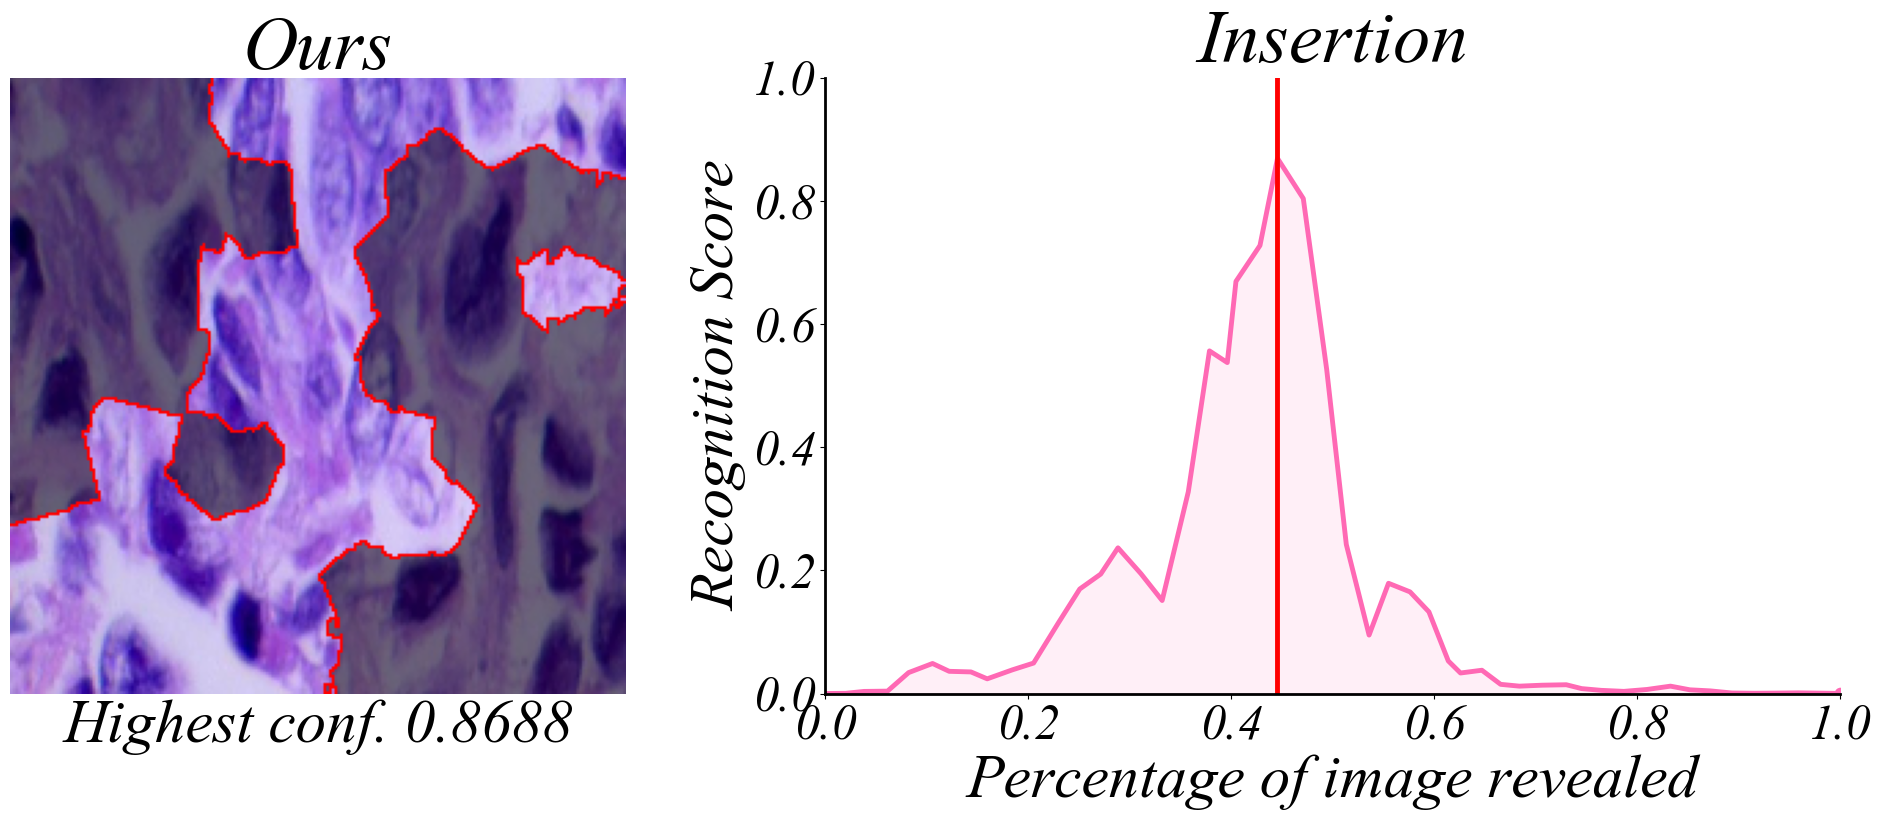

In [57]:
visualization(img_input, submodular_image_set, saved_json_file)